## Customer Lifetime Value

The purporse of the customer lifetime value metric is to asses the financial value of each customer. Understanding and acting on customer lifetime value is important to drive: the acquisition/retention resource allocation and the individually targeted actions. 

It is most commonly defined as the sum of the discounted net cash flows generated by a customer during his / her relationship with the company. According  to  this  formula  for  the  computation  of  the  lifetime value  of  a  particular customer, we must forecast the revenues and costs at each future time step and estimate the remaining   time   interval   (ie   the   lifetime)   during   which   the   customer   generates revenues for the company. Since  our  data  include  only  information  about  revenues  not  costs,  we  focus  our  analysis on revenues not profits. 

For this purporse we use Lifetimes, a Python library that can be used to both estimate if these customers are still alive and predict how much more they will interact based on their existing history. 



In [1]:
# Import libraries
import pandas as pd
import lifetimes
import numpy as np
import datetime as dt
import matplotlib
%matplotlib inline

We onvert string to datetime object and we load the data

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [3]:
data_raw = pd.read_csv("clientes_unicos.csv", sep=",", parse_dates= ['date_of_birth', 'departure_date_leg'], 
                       date_parser= dateparse)

## Residual Lifetime Value

We use the beta-geometric/NBD model, an alternative to the Pareto/NBD model developed to describe repeat-buying behavior in a setting where customers buy at a steady rate (albeit in a stochastic manner) for a period of time, and then become inactive. More specifically, the churn rate is modelled using the Pareto (exponential-gamma mixture) timing model but while the customer is still active/alive, his repeat-buying behavior is modelled using the negative binomial (Poisson-gamma) counting mode. Thus, this model yields the expressions required for making individual-level statements about future buying behavior.

We select the features of the model

In [4]:
data = data_raw[['document_number', 'age', 'date_of_birth', 'departure_date_leg', 'route', 'revenue_amount_seg']]

### Feature engineering



We create the input variables of the model taking into account the dates of the fligth purchase. For estimating the probability of a new purchase, the BG/NBD model needs three variables: recency, actual age of the customer, age of the customer at the his/her first purchase.

Thus, we set as Now variable the most recent date of the database. Recency is calculated as the difference between now and the last purchase. First is the difference between date of birth of the customer and his/her first purchase

In [5]:
data['NOW'] = dt.datetime(2014,4,8)

In [6]:
data['Recency'] = data['NOW']-data['departure_date_leg']
data['First'] = data['departure_date_leg'] - data['date_of_birth']


F represents the number of repeat purchases of an specific route that the customer has made (also called frequency). T represents the age of the customer. t_x represents the age of the customer when they made their most recent purchases and R stands for recency. 'M' is the economic value of each transaction to be used in a second model for estimating the customer's lifetime value.

In [90]:
rfmTable = data.groupby(['document_number']).agg({'Recency': lambda x: x.min().days, 
                                                   'route': lambda x: len(x),  
                                                   'First': lambda x: (x.min().days)/365,# First
                                                    'age': lambda x:  x.max(),
                                                  'revenue_amount_seg': lambda x: x.sum()
                                                                                               }) # A

In [96]:
rfmTable.rename(columns={'Recency': 'R', 'route': 'F', 'First': 't_x' , 'age': 'T', 'revenue_amount_seg': 'M'}, inplace=True)

In [97]:
rfmTable.sample(15)

,F,M,R,T,t_x
document_number,,,,,
02676BB12,4,0.00,127,55,52
77545FT89,1,0.00,295,78,75
25538BM20,2,0.00,233,33,30
82990FS96,3,2350.52,206,38,35
35037BJ40,2,0.00,137,46,44
68078BD83,2,572.79,205,34,31
929428224,1,5163.35,228,51,48
85693BL76,1,184.00,31,34,32
407035053,4,962.96,156,47,44


## Modelling and validation

As we mention we select the BG/NBD model to be of use in a forward-looking customer-base analysis, obtaining  a log-likelihood function that yields the the expected number of transactions in a future period of length "t" for taking into account the past observed behaviour of the customer. 


In [98]:
from lifetimes import BetaGeoFitter 
bgf = BetaGeoFitter()
bgf.fit(rfmTable['F'], rfmTable['t_x'], rfmTable['T'])
print bgf


<lifetimes.BetaGeoFitter: fitted with 231974 subjects, r: 4.84, alpha: 67.24, a: 0.00, b: 777.89>


After fitting we can visualize the relationship between Recency and Frecuency with a matrix which computes the number of expected transactions a customer is going to make in the next period given his o her recency

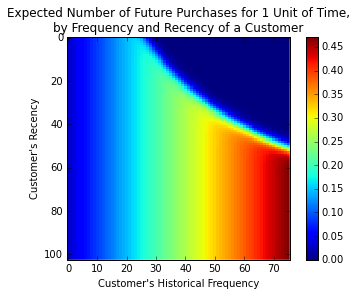

In [99]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)


We can see that that customers that has a frequency more than 70 times and their lastest purchase was when they were at least a recency of 60 weeks, then they are your best customer top-right corner and the more inactive are You coldest customers are those that in the bottom-left corner: they bought a lot quickly, and we haven't seen them in weeks.

Another interesting matrix to look at is the probability of still being alive:

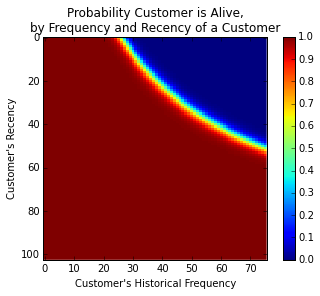

In [100]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

We  see that the customer who has made 67 purchases, and bought very recently from us, is probably going to buy again in the next period. We can chek this outcome ranking the passangers them from highest expected purchases in the next period to lowes using the model that will predict a customer's expected purchases in the next period using their history

In [101]:
t = 1
rfmTable['predicted_purchases'] = rfmTable.apply(lambda r: bgf.conditional_expected_number_of_purchases_up_to_time(t, r['F'], r['t_x'], r['T']), axis=1)
rfmTable.sort('predicted_purchases').tail(5)

,F,M,R,T,t_x,predicted_purchases
document_number,,,,,,
826594388,60,2648.08,37,42,39,0.593539
625151404,68,4143.36,2,52,49,0.610853
984922457,64,2974.90,35,40,36,0.641907
777089502,67,3915.37,6,41,38,0.663692
92897BN10,75,8329.31,43,50,47,0.680979


To asses the model we compare real data when the predictions of the model

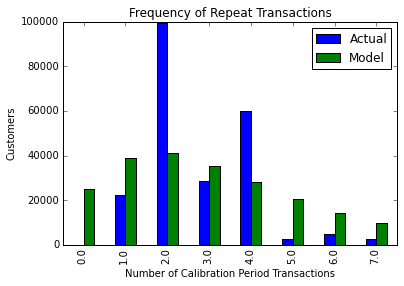

In [102]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)


In [104]:
t = 10 #predict purchases in 10 periods
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, rfmTable['F'], rfmTable['t_x'], rfmTable['T']).head()


document_number
000005678    0.658493
00000BS96    0.529220
00000S942    0.948041
00001BG93    0.593512
00002926     1.154214
dtype: float64

### Predicting future revenues

So far we just focused mainly on transactions' occurrences to estime the residual Lifetime Value.focuwe didn't take into account the economic value of each transaction and we focused mainly on transactions' occurrences. To estimate the revenue customer's lifetime value we use the Gamma-Gamma submodel on the transaction whose frecuency is higher than 0 (i.e. profits or revenues). The Gamma-Gamma model is used to to predict likely spend per transaction in the future at the customer level.

In [105]:
returning_customers = rfmTable[rfmTable['F']>0]

returning_customers.head()

,F,M,R,T,t_x,predicted_purchases
document_number,,,,,,
000005678,4,2900.00,181,67,64,0.065849
00000BS96,2,263.00,3,62,60,0.052922
00000S942,4,212.96,218,26,23,0.094804
00001BG93,2,315.44,34,48,46,0.059351
00002926,8,2577.22,24,44,41,0.115421


### The Gamma-Gamma model and the independence assumption

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [106]:
returning_customers[['M', 'F']].corr()

,M,F
M,1.000000,0.436242
F,0.436242,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [107]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['F'], 
        returning_customers['M'])
print ggf    

<lifetimes.GammaGammaFitter: fitted with 231974 subjects, p: 0.90, q: 0.34, v: 0.28>


We can now estimate the average transaction value:

In [108]:
print ggf.conditional_expected_average_profit(
         rfmTable['F'],
         rfmTable['M']
    ).head()

document_number
000005678    3546.163626
00000BS96     413.998315
00000S942     260.490891
00001BG93     496.501704
00002926     2835.568409
dtype: float64


In [109]:
print "Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        rfmTable['F'],
        rfmTable['M']
    ).mean(),
    rfmTable[rfmTable['F']>0]['M'].mean())

Expected conditional average profit: 857.367261852, Average profit: 594.261230957


While for computing the total CLV using the DiscountCash Flow method  adjusting for cost of capital:

In [110]:
# refit the BG model taking into account the economic value
bgf.fit(rfmTable['F'], rfmTable['t_x'], rfmTable['T'])

print ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfmTable['F'],
    rfmTable['R'],
    rfmTable['T'],
    rfmTable['M'],
    time=12, # months
    discount_rate=0.7
).sample(5)

document_number
4075QU51     3395.076498
17265BR18       0.458219
36312BK93    2081.834992
984889478     767.534036
562317956       0.263475
Name: clv, dtype: float64
